In [11]:
import warnings
warnings.filterwarnings('ignore')
import yaml
import string
import logging
logging.basicConfig(level=logging.CRITICAL)

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

#import sys
##sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [24]:
var = 'pr'
task = 'xvalidation'
units = 'mm'

In [ ]:
def get_assessment_time_bounds(task):
    """Get assessment time bounds for given GCM/task combination"""

    start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    return start_date, end_date

In [ ]:
start_date, end_date = get_assessment_time_bounds(task)

In [3]:
# Metric calculation

def calc_mean(da, var):
    """Calculate the mean"""
    
    if var == 'pr':
        mean = da.groupby('time.year').sum(dim="time").mean(dim='year')
    else:
        mean = da.groupby('time.year').mean(dim="time").mean(dim='year')
        
    return mean

In [4]:
def get_obs_data(var, start_date, end_date):
    """Get obs data"""
    
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    
    return calc_mean(da_obs, var)


def get_gcm_data(var, gcm, start_date, end_date):
    """Get reference/raw GCM data."""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    try:
        da_gcm = utils.get_npcp_data(var, gcm, 'GCM', 'raw', 'task-reference', start_date, end_date)
        return calc_mean(da_gcm, var)
    except OSError:
        print(f"Warning: GCM raw data for {gcm} is missing for the period {start_date} to {end_date}.")
        return None
    

def get_rcm_data(var, gcm, rcm, start_date, end_date):
    """Get reference/raw RCM data"""
    
    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']

    try:
        da_rcm = utils.get_npcp_data(var, gcm, rcm, 'raw', 'task-reference', start_date, end_date)
        return calc_mean(da_rcm, var)
    except OSError:
        print(f"Warning: RCM raw data for {gcm}/{rcm} is missing for the period {start_date} to {end_date}.")
        return None


def get_bias_corrected_rcm_data(var, gcm, rcm, task, start_date, end_date):
    """Get bias corrected RCM data"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']
    
    bc_methods = ['ecdfm', 'qme', 'mbcn', 'mrnbc']
    # TODO: Add additional bias correction methods as data becomes available 
    if task == 'xvalidation':
        bc_methods.append('qdc')

    da_dict = {}
    for bc in bc_methods:
        try:
            da = utils.get_npcp_data(var, gcm, rcm, bc, f'task-{task}', start_date, end_date)
            da_dict[bc] = calc_mean(da, var)
        except OSError:
            print(f"Warning: Bias corrected RCM data for {gcm}/{rcm} using {bc} is missing for the period {start_date} to {end_date}.")
            da_dict[bc] = None

    return da_dict


def get_bias_corrected_gcm_data(var, gcm, task, start_date, end_date):
    """Get bias corrected GCM data"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert task in ['historical', 'xvalidation']
    
    bc_methods = ['ecdfm']
    if task == 'xvalidation':
        bc_methods.append('qdc')

    da_dict = {}
    for bc in bc_methods:
        try:
            da = utils.get_npcp_data(var, gcm, 'GCM', bc, f'task-{task}', start_date, end_date)
            da_dict[bc] = calc_mean(da, var)
        except OSError:
            print(f"Warning: Bias corrected GCM data for {gcm} using {bc} is missing for the period {start_date} to {end_date}.")
            da_dict[bc] = None

    return da_dict

In [6]:
da_obs = get_obs_data(var, start_date, end_date)

In [22]:
gcm_dict = {}
gcms = ['CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
for gcm in gcms:
    gcm_dict[gcm] = get_gcm_data(var, gcm, start_date, end_date)
da_gcms = xr.concat(gcm_dict.values(), dim='model')
da_gcm_max = da_gcms.max(dim='model')
da_gcm_min = da_gcms.min(dim='model')
da_gcm_diff = da_gcm_max - da_gcm_min
da_gcm_diff = da_gcm_diff.compute()

In [28]:
rcm_dict = {}
rcm_diff_dict = {}
rcms = ['BOM-BARPA-R', 'CSIRO-CCAM-2203']
for gcm in gcms:
    rcm_dict[gcm] = {}
    for rcm in rcms:
        rcm_dict[gcm][rcm] = get_rcm_data(var, gcm, rcm, start_date, end_date)
    da_rcms = xr.concat(rcm_dict[gcm].values(), dim='model')
    da_rcm_max = da_rcms.max(dim='model')
    da_rcm_min = da_rcms.min(dim='model')
    da_rcm_diff = da_rcm_max - da_rcm_min
    rcm_diff_dict[gcm] = da_rcm_diff.compute()

In [30]:
da_rcm_diff = xr.concat(rcm_diff_dict.values(), dim='model')
da_rcm_diff = da_rcm_diff.mean(dim='model')

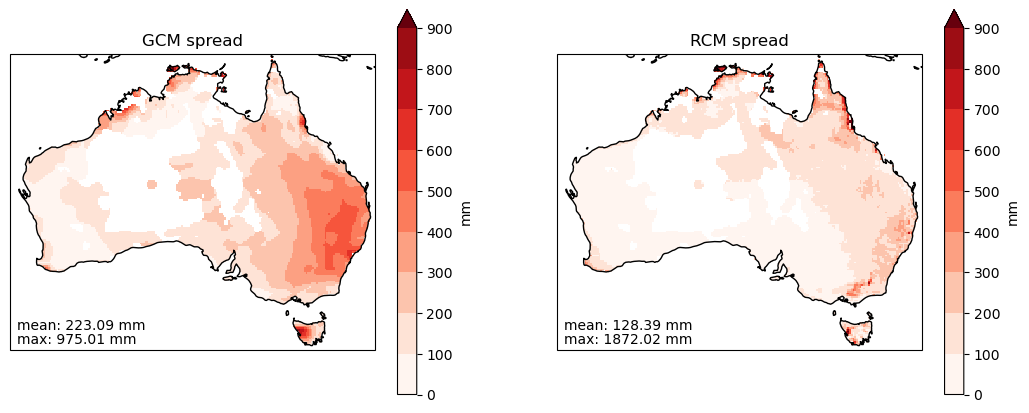

In [34]:
#frac = (diff / da_obs) * 100

levels = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
cmap = 'Reds'

gcm_diff = utils.clip_data(da_gcm_diff, utils.get_aus_shape())
rcm_diff = utils.clip_data(da_rcm_diff, utils.get_aus_shape())

if var == 'pr':
    ob_fractions = utils.get_pr_weights(gcms[0], task)
    gcm_diff = utils.mask_by_pr_ob_fraction(gcm_diff, ob_fractions, threshold=0.9)
    rcm_diff = utils.mask_by_pr_ob_fraction(rcm_diff, ob_fractions, threshold=0.9)
 
mean_gcm_diff = float(np.nanmean(gcm_diff))
max_gcm_diff = float(np.nanmax(gcm_diff))
mean_rcm_diff = float(np.nanmean(rcm_diff))
max_rcm_diff = float(np.nanmax(rcm_diff))
    
fig = plt.figure(figsize=[20, 5])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
im1 = gcm_diff.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels,
    extend='max',
    cbar_kwargs={'label': units},
)
ax1.set_title('GCM spread')
ax1.text(0.02, 0.07, f'mean: {mean_gcm_diff:.2f} {units}', transform=ax1.transAxes, fontsize='medium')
ax1.text(0.02, 0.02, f'max: {max_gcm_diff:.2f} {units}', transform=ax1.transAxes, fontsize='medium')
ax1.coastlines()

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
im2 = rcm_diff.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels,
    extend='max',
    cbar_kwargs={'label': units},
)
ax2.set_title('RCM spread')
ax2.text(0.02, 0.07, f'mean: {mean_rcm_diff:.2f} {units}', transform=ax2.transAxes, fontsize='medium')
ax2.text(0.02, 0.02, f'max: {max_rcm_diff:.2f} {units}', transform=ax2.transAxes, fontsize='medium')
ax2.coastlines()

plt.show()